## Homework Week 4


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

from tqdm.auto import tqdm

c:\Users\david\Desktop\Zoomcamps\machine-learning-zoomcamp_homeworks\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

In [6]:
!wget $url -O data.csv 

--2023-10-08 18:35:38--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: 'data.csv'

     0K .......... .......... .......... .......... ..........  3% 1.93M 1s
    50K .......... .......... .......... .......... ..........  6% 3.91M 1s
   100K .......... .......... .......... .......... .......... 10% 5.19M 0s
   150K .......... .......... .......... .......... .......... 13% 8.45M 0s
   200K .......... .......... .......... .......... .......... 17% 9.91M 0s
   250K .......... .......... .......... .......... .......... 20% 13.7M 0s
   300K .......... .......... .......... .......... .......... 24% 6.23M 0s
   350K ..

In [7]:
cols = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP",
]
df_full = pd.read_csv("data.csv", usecols=cols)
df_full.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


## Data Prep


In [8]:
numerical = ["year", "engine_hp",
             "engine_cylinders", "highway_mpg", "city_mpg"]
categorical = ["make", "model", "transmission_type", "vehicle_style"]

df = df_full
df.columns = df.columns.str.replace(" ", "_").str.lower()

df = df.fillna(0)

In [9]:
mean_price = df.msrp.mean()
mean_price

40594.737032063116

In [10]:
df["above_average"] = (df.msrp > mean_price).astype(int)
del df["msrp"]
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [11]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(
    df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

## Question 1


In [12]:
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[n])
    print(n, "-", round(auc, 3))

year - 0.688
engine_hp - 0.917
engine_cylinders - 0.766
highway_mpg - 0.633
city_mpg - 0.673


**Answer = engine_hp**


## Question 2


In [13]:
features = categorical + numerical

In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient="records")
X_val = dv.transform(val_dict)

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.979

**Answer = 0.979**


## Question 3


In [15]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = y_val == 1
    actual_negative = y_val == 0

    predict_positive = y_pred >= t
    predict_negative = y_pred < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [16]:
columns = ["threshold", "tp", "fp", "fn", "tn"]
df_scores = pd.DataFrame(scores, columns=columns)

df_scores["p"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["r"] = df_scores.tp / (df_scores.tp + df_scores.fn)

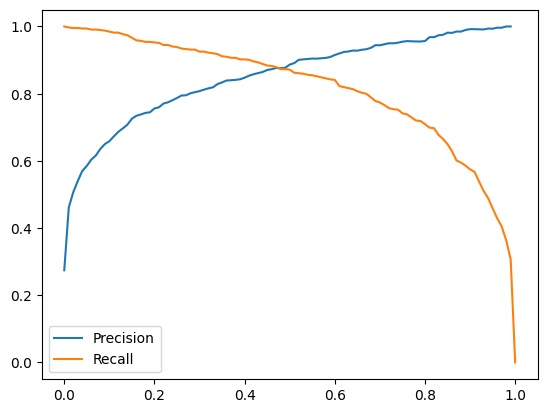

In [17]:
plt.plot(df_scores.threshold, df_scores.p, label="Precision")
plt.plot(df_scores.threshold, df_scores.r, label="Recall")
plt.legend()
plt.show()

**Answer = 0.48**


## Question 4


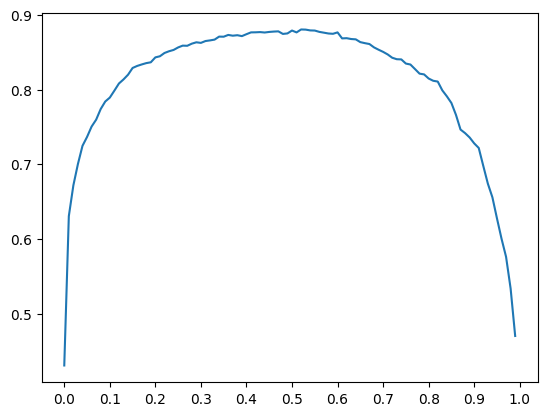

In [18]:
df_scores["f1"] = 2 * ((df_scores.p * df_scores.r) /
                       (df_scores.p + df_scores.r))


plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

**Answer = 0.52**


## Question 5


In [19]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df[features].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

NameError: name 'C' is not defined

**Answer = 0.003**


## Question 6


In [21]:
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(
        "C=%s %.3f +- %.3f" % (C, round(np.mean(scores), 3),
                               round(np.std(scores), 3))
    )

 25%|██▌       | 1/4 [00:00<00:02,  1.10it/s]

C=0.01 0.952 +- 0.002


 50%|█████     | 2/4 [00:01<00:01,  1.11it/s]

C=0.1 0.972 +- 0.002


 75%|███████▌  | 3/4 [00:02<00:00,  1.12it/s]

C=0.5 0.978 +- 0.001


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

C=10 0.983 +- 0.003


**Answer = 10**
